In [2]:
pip install skorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 6.7 MB/s eta 0:00:00


In [3]:
import os, glob
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skorch.callbacks import EpochScoring, ProgressBar


from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Dataset
class WeaponDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        filename = self.image_files[idx]
        img_path = os.path.join(self.img_dir, filename)
        label_path = os.path.join(self.label_dir, os.path.splitext(filename)[0] + ".txt")

        image = Image.open(img_path)
        if getattr(image, "is_animated", False):
            image.seek(0)
        if image.mode == 'P' or 'transparency' in image.info:
            image = image.convert("RGBA")
        if image.mode == 'RGBA':
            image = image.convert("RGB")
        if image.mode != 'RGB':
            image = image.convert("RGB")  # Ensure 3 channels
        if self.transform:
            image = self.transform(image)

        label_tensor = torch.zeros(9)
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    cls = int(line.strip().split()[0])
                    label_tensor[cls] = 1

        return image, label_tensor

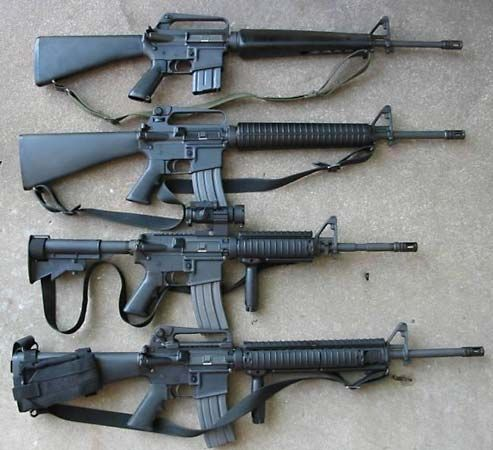

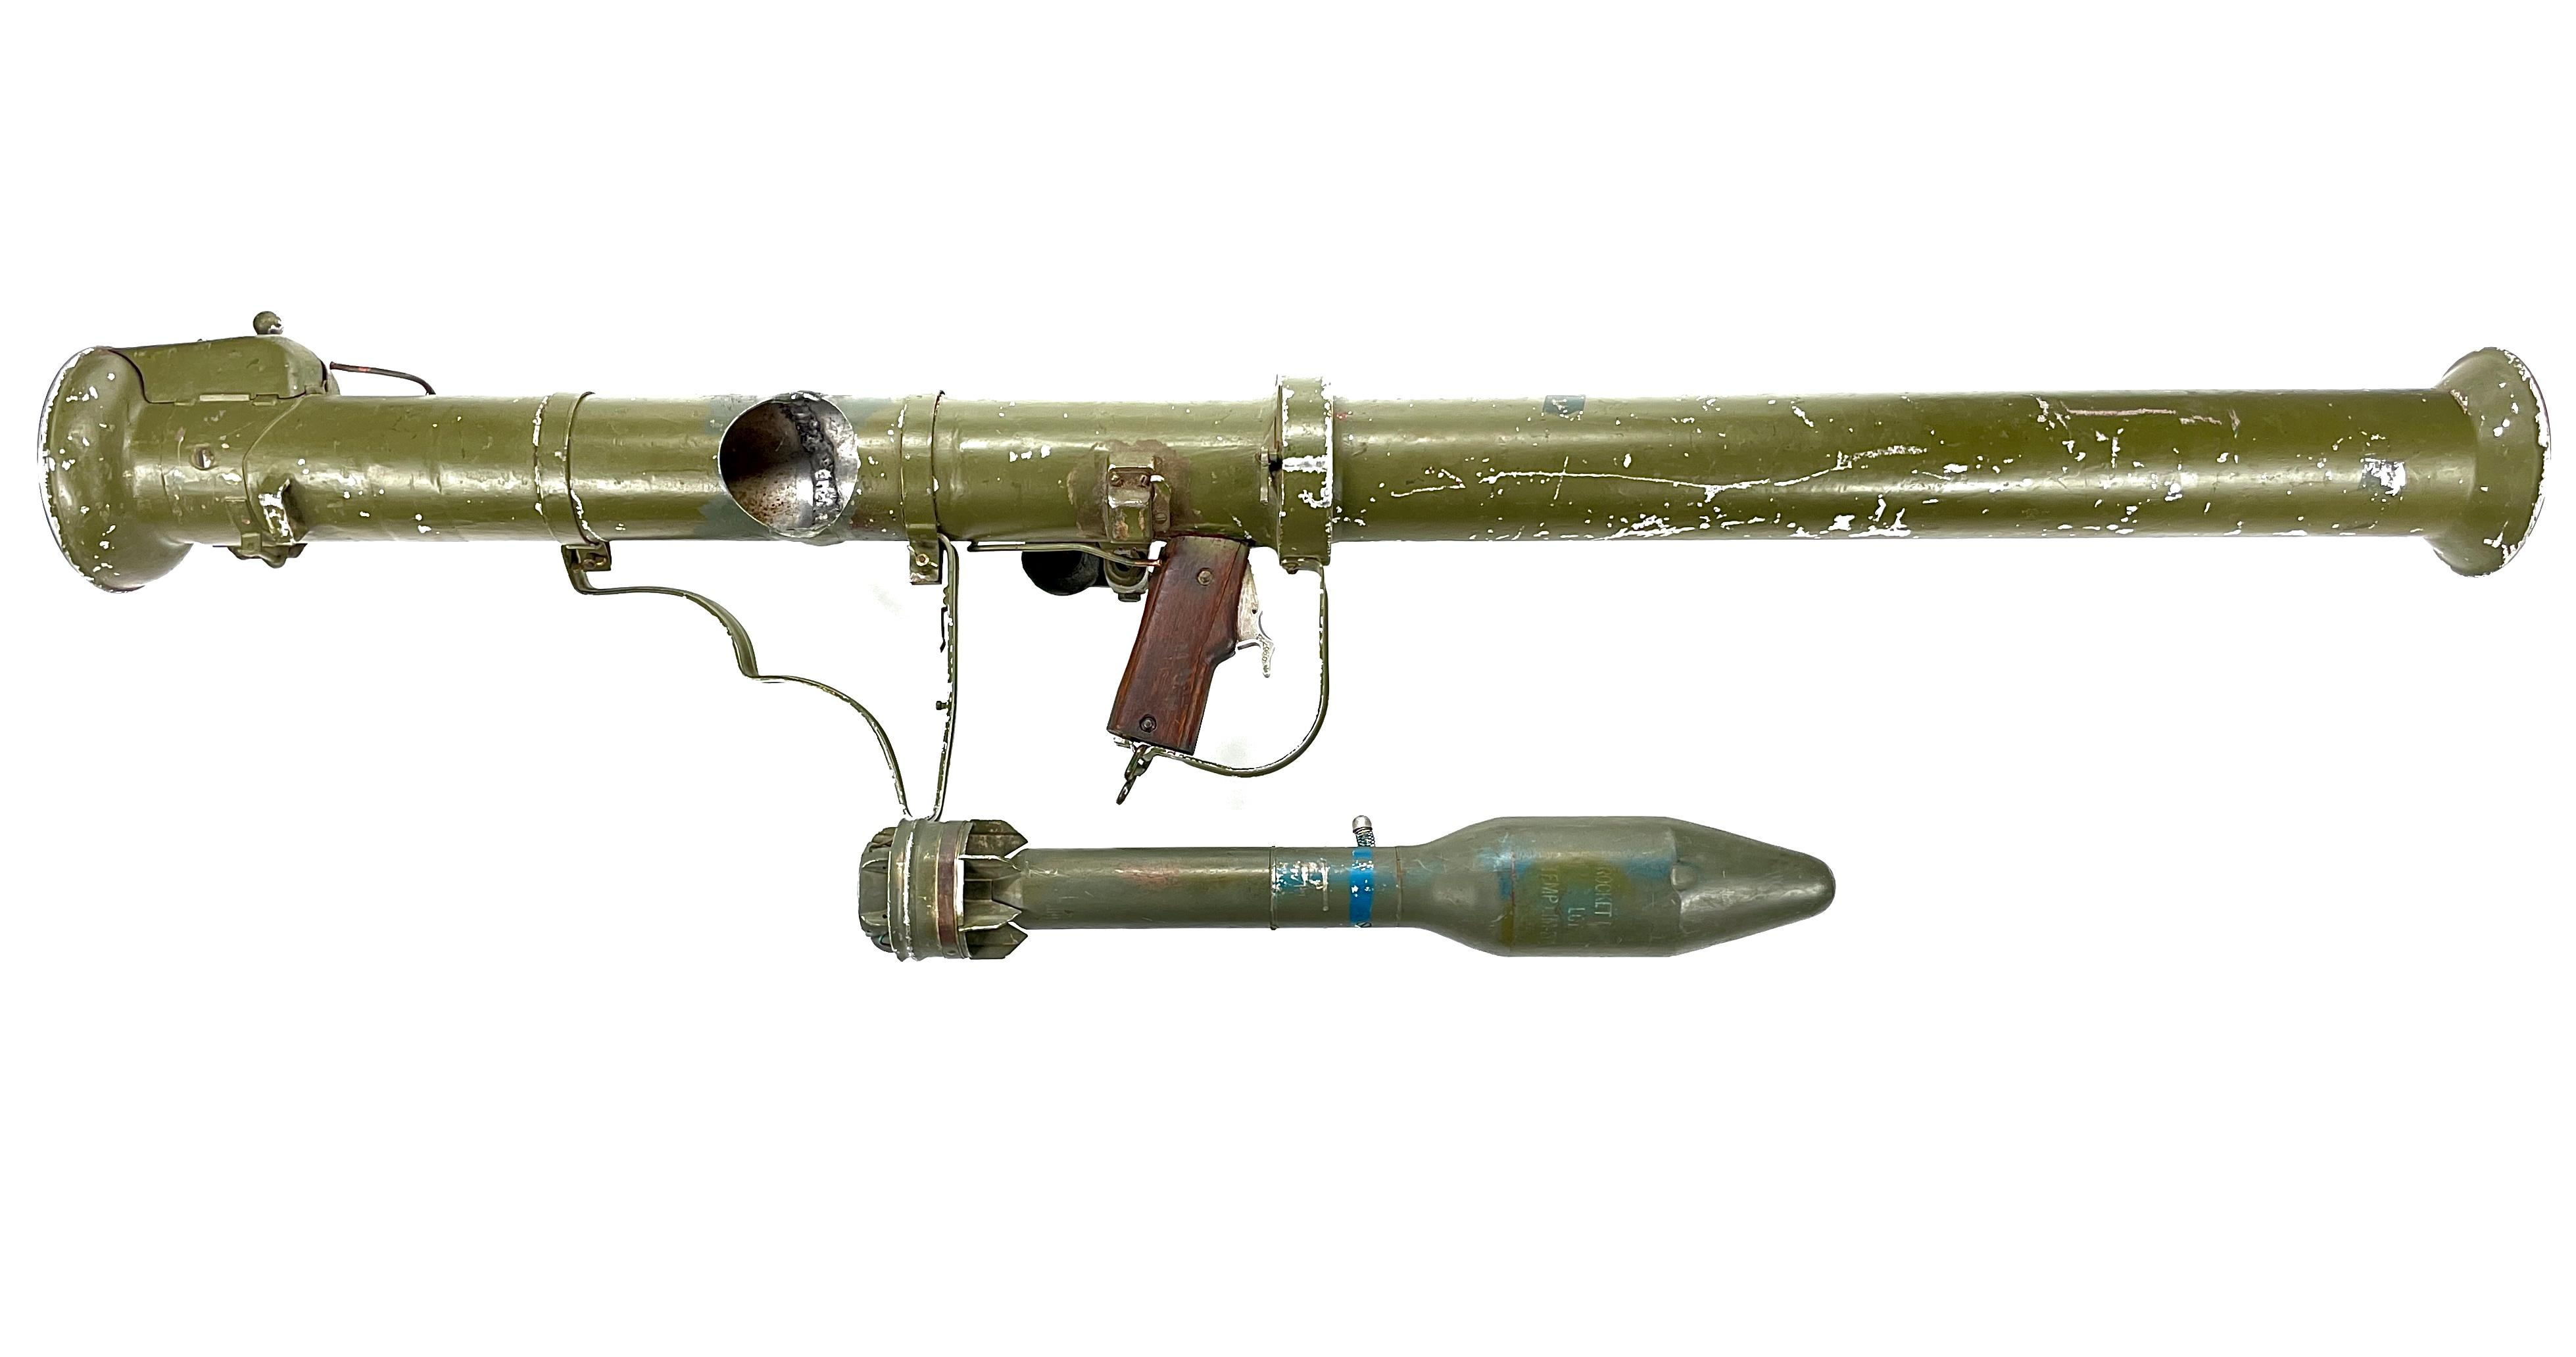

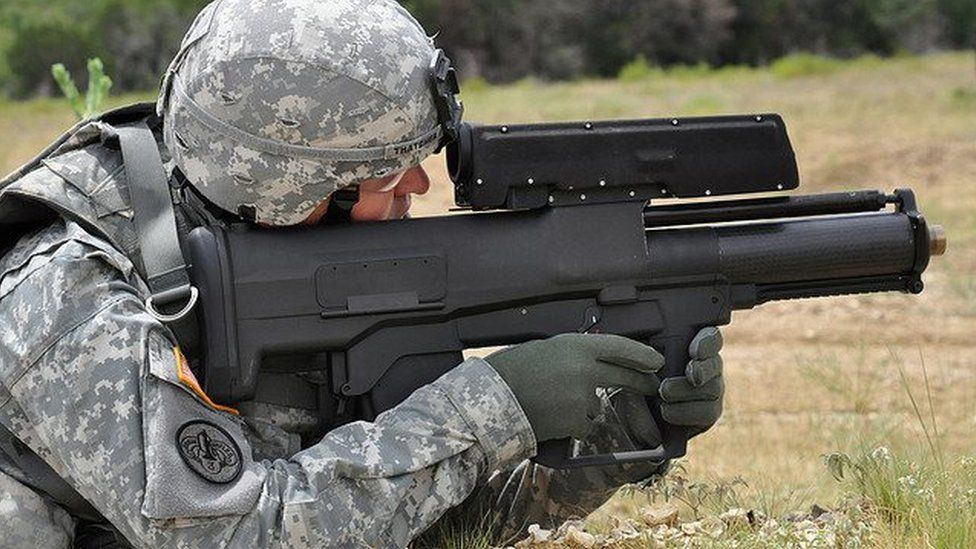

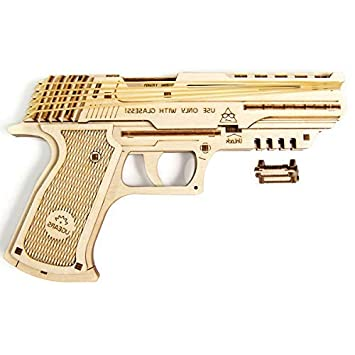

In [6]:
# CNN
class DeepCNN(nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512), nn.ReLU(), nn.AdaptiveAvgPool2d((4, 4))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 9),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.classifier(x)
        return x

In [16]:
from torchvision import transforms
# Transforms
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

In [17]:
# Data paths
train_img_dir = "/content/drive/MyDrive/Colab Notebooks/weapon_detection/train/images"
train_lbl_dir = "/content/drive/MyDrive/Colab Notebooks/weapon_detection/train/labels"
val_img_dir = "/content/drive/MyDrive/Colab Notebooks/weapon_detection/val/images"
val_lbl_dir = "/content/drive/MyDrive/Colab Notebooks/weapon_detection/val/labels"

train_data = WeaponDataset(train_img_dir, train_lbl_dir, transform=transform)
val_data = WeaponDataset(val_img_dir, val_lbl_dir, transform=transform)

In [18]:
# Hyperparameter grid
from itertools import product
param_grid = {
    "lr": [0.001, 0.0005],
    "dropout": [0.3, 0.5],
    "batch_size": [4, 8],
    "optimizer": ["adam", "sgd"],
    "epochs": [10,20]
}

results = []

for lr, dropout, batch_size, opt_name, epochs in product(
    param_grid["lr"], param_grid["dropout"],
    param_grid["batch_size"], param_grid["optimizer"],
    param_grid["epochs"]):
  pass
# DataLoader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
import torch.optim as optim
# Model
model = DeepCNN(dropout=dropout).to(device)
loss_fn = nn.BCELoss()

if opt_name == "adam":
    optimizer = optim.Adam(model.parameters(), lr=lr)
else:
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
# Train
model.train()
for _ in range(epochs):
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = loss_fn(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

from sklearn.metrics import precision_score, recall_score, f1_score

# Eval
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for x, y in val_loader:

        x = x.to(device)
        pred = (model(x).cpu().numpy() > 0.5).astype(int)
        all_preds.append(pred)
        all_true.append(y.numpy())

y_pred = np.vstack(all_preds)
y_true = np.vstack(all_true)

p = precision_score(y_true, y_pred, average='micro', zero_division=0)
r = recall_score(y_true, y_pred, average='micro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)

result = {
    "lr": lr,
    "dropout": dropout,
    "batch_size": batch_size,
    "optimizer": opt_name,
    "epochs": epochs,
    "precision": round(p, 4),
    "recall": round(r, 4),
    "f1": round(f1, 4)
}
results.append(result)
print(f"[✓] Config: lr={lr}, dropout={dropout}, batch_size={batch_size}, optimizer={opt_name}")
print(f"    → Precision={p:.4f}, Recall={r:.4f}, F1={f1:.4f}")
print("-" * 60)

# Final sorted results
#df = pd.DataFrame(results).sort_values(by="f1", ascending=False).reset_index(drop=True)
#print("\n Top Configurations by F1 Score:")
#print(df.head())

[✓] Config: lr=0.0005, dropout=0.5, batch_size=8, optimizer=sgd
    → Precision=0.7413, Recall=0.7020, F1=0.7211
------------------------------------------------------------


In [10]:
# Final sorted results
df = pd.DataFrame(results).sort_values(by="f1", ascending=False).reset_index(drop=True)
print("\n Top Configurations by F1 Score:")
print(df.head())


 Top Configurations by F1 Score:
       lr  dropout  batch_size optimizer  epochs  precision  recall      f1
0  0.0005      0.5           8       sgd      20     0.7413   0.702  0.7211


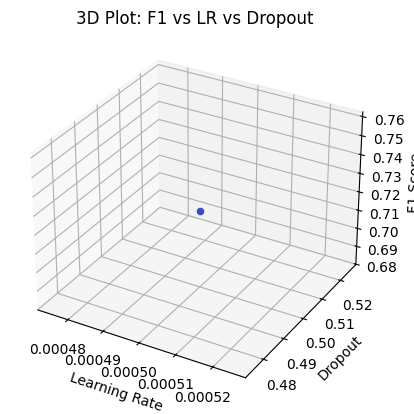

In [11]:
 from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df["lr"], df["dropout"], df["f1"], c=df["f1"], cmap='coolwarm')
ax.set_xlabel("Learning Rate")
ax.set_ylabel("Dropout")
ax.set_zlabel("F1 Score")
plt.title("3D Plot: F1 vs LR vs Dropout")
plt.show()

In [13]:
CLASS_NAMES = [
    "Automatic Rifle", "Bazooka", "Grenade Launcher", "Handgun", "Knife",
    "Shotgun", "SMG", "Sniper", "Sword"
]

In [14]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def show_prediction(image_tensor, pred, true):
    image = F.to_pil_image(image_tensor.cpu())
    plt.imshow(image)
    plt.axis('off')

    pred_labels = [CLASS_NAMES[i] for i in range(len(pred)) if pred[i]]
    true_labels = [CLASS_NAMES[i] for i in range(len(true)) if true[i]]

    plt.title(f"Predicted: {', '.join(pred_labels)}\nTrue: {', '.join(true_labels)}", fontsize=10)
    plt.show()

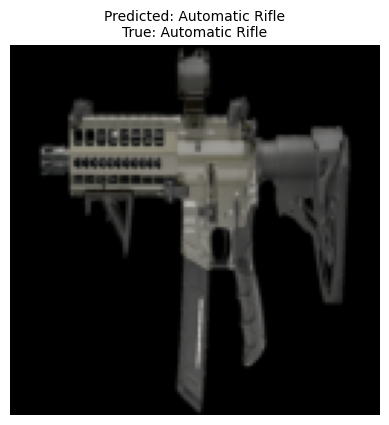

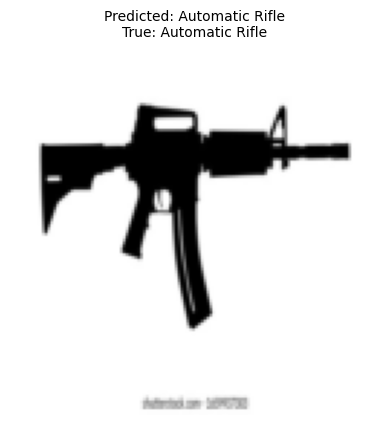

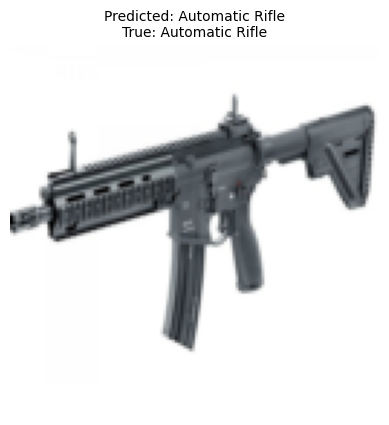

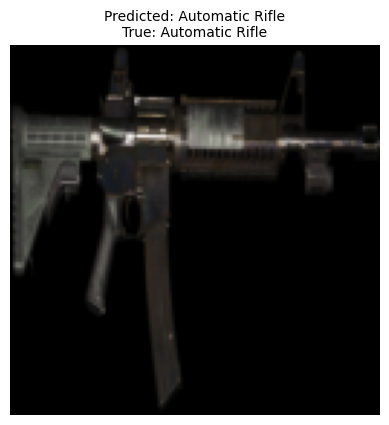

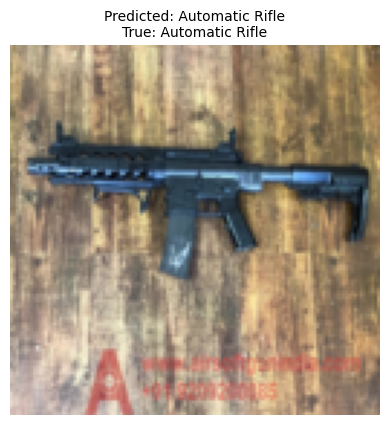

In [15]:
model.eval()
shown = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.to(device)).cpu().numpy()
        preds = (outputs > 0.5).astype(int)

        for i in range(len(imgs)):
            show_prediction(imgs[i], preds[i], labels[i].numpy())
            shown += 1
            if shown >= 5:  # show 5 examples
                break
        if shown >= 5:
            break